<!-- This cell is automatically updated by tools/tutorial-cell-updater.py -->
<!-- The contents are initialized from tutorials/notebook-header.md -->

[<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>](https://colab.research.google.com/github/speechbrain/speechbrain/blob/develop/docs/tutorials/nn/conformer-streaming-asr.ipynb)
to execute or view/download this notebook on
[GitHub](https://github.com/speechbrain/speechbrain/tree/develop/docs/tutorials/nn/conformer-streaming-asr.ipynb)

# Streaming Speech Recognition with Conformers

<!-- TODO: images should be included as base64 instead to work properly everywhere... -->

Automatic Speech Recognition (ASR) models are often only designed to transcribe an entire large chunk of audio and are unsuitable for usecases like live stream transcription, which requires low-latency, long-form transcription.

This tutorial introduces the Dynamic Chunk Training approach and architectural changes you can apply to make the Conformer model streamable. It introduces the tooling for training and inference that SpeechBrain can provide for you.
This might be a good starting point if you're interested in training and understanding your own streaming models, or even if you want to explore improved streaming architectures.

The model and training procedure described here are not state-of-the-art, but it is a reasonably good and modern end-to-end approach. It has successfully been applied as the following recipes (non-exhaustive list):

- [`LibriSpeech/ASR/transducer`](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech/ASR/transducer) ([pre-trained on HuggingFace](https://huggingface.co/speechbrain/asr-streaming-conformer-librispeech))
- [`VoxPopuli/ASR/transducer`](https://github.com/speechbrain/speechbrain/tree/develop/recipes/VoxPopuli/ASR/transducer)
- [`CommonVoice/ASR/transducer`](https://github.com/speechbrain/speechbrain/tree/develop/recipes/CommonVoice/ASR/transducer) (French, Italian)

## Recommended prerequisites

- [Speech Recognition From Scratch](https://speechbrain.readthedocs.io/en/latest/tutorials/tasks/speech-recognition-from-scratch.html)

### Installing SpeechBrain

In [1]:
%%capture
# Installing SpeechBrain via pip
BRANCH = 'develop'
!python -m pip install git+https://github.com/speechbrain/speechbrain.git@$BRANCH

In [ ]:
%%capture
%pip install matplotlib

## What a streaming model needs to achieve

We need a fine-grained way to restrict and remember context so that the model attends only on **recent context** and **not future frames**. That strategy must somehow be **consistent between training and inference**.

Traditional models might have the luxury of reusing the same forward code path for both training and inference. Training and inference when streaming kind of have opposite performance characteristics, and this results in special casing in some layers.

- For inference, we generally need to process outputs chunk-by-chunk as they come in, and this usually implies caching some past hidden state at different layers.
- For training, we prefer to pass in a large batch of whole utterances, once, to maximize GPU occupancy and lower Python and CUDA kernel launching overhead. Thus, we would prefer to enforce these restrictions by masking.

## Architectural Changes to the Conformer

<img src="../assets/conformer-simple.png" alt="Simplified Conformer Diagram" width="300"/>

The above is a (very) simplified diagram of the vanilla Conformer architecture as used in one of our models, to read from top to bottom.  
Colored bricks are the ones that require us to be careful when streaming, as they propagate information across time steps.

### Chunked Attention

#### What is Causal Attention?

If you are familiar with Transformer architectures, you may be familiar with causal attention. In a nutshell, causal attention makes it so that the output frame at timestep $t$ cannot attend to an input from a "future" timestep ($t+1$, $t+2$, etc.).

This directly implies that if you want to predict the output of the model at timestep $t$, you only need "current" and "past" inputs ($t$, $t-1$, $t-2$, etc.). This is important to us, because we _don't_ know the future frames!

Causal attention is very simple to apply (naively), and actually fits the bill for streaming ASR... But we won't use it here.

#### What is Chunked Attention, and why do we prefer it?

Causal attention is simple to implement, but for streaming ASR, it is found to disproportionately degrade the Word Error Rate. <!-- TODO: source -->  
For this reason, chunked attention is often chosen in streaming attentive models instead.

Conceptually, chunked attention introduces the idea of _chunks_ that group a given amount of frames (`chunk_size`). For example, if you were to have a chunk size of 4, then you would look at your input like this:

<img src="../assets/attention-chunking.png" alt="Chunking of inputs" width="800"/>

**Frames within a chunk can attend to each other**. This retains more of the expressive power of attention compared to causal attention.  
Chunks can also attend to past chunks, but we **limit how far into the past** to reduce the computational and memory cost at inference time (`left_context_chunks`).

At training time, we enforce this using an **attention mask**. An attention mask answers the question: Can the `j`-th output frame attend to the `i`-th input frame?  
As such, it is defined as a boolean tensor defined with a shape of `(inputs, outputs)`. <!-- TODO check type and shape --> Here follows an example of one:

<img src="../assets/attn-restrict.png" alt="Chunked Attention example diagram" width="800"/>

#### Chunked Attention during inference

When designing streaming models, we need to be very careful about how dependencies between output frames and input frames propagate across layers.

For instance, thinking back about _causal_ attention, you might wonder if we could have regained some accuracy by allowing the output frame at timestep $t$ to attend to an input frame at timestep $t+1$, i.e. giving it some "right"/future context at every layer.  
_Yes,_ we _could_, and it does help somewhat, but consider the implications when stacking layers! For instance, consider two layers of attention, where $a$ is the input, $b$ is the output of the first layer, and $c$ is the output of the second layer: $c_t$ will attend to $b_{t+1}$ (among others), which itself will attend to $a_{t+2}$. This gets worse in practice, when we might have something like 12 or 17 layers.  
This is cumbersome, and will likely have a negative effect on latency (we'd need to buffer a bunch of "future" frames) and memory/computational cost.

On the other hand, chunk attention plays very nicely with this. **Let's ignore left context first.** The following example focuses on the 4th chunk of the input, and on which frames effectively depend on/attend to which:

<img src="../assets/attention-chunking-no-lc.png" alt="Chunked Attention (example with no left context)" width="800"/>

Ignoring left context, frames within one chunk may attend to each other. If you stack attention layers, the **boundaries of chunks remain the same across layers**.

Now, let's add left context. In the following example, we will assume a left context size of 1 chunk. For clarity, we omit the connections for <span style="color: red">12,13,14</span> but they attend to the _same frames_ as <span style="color: red">15</span>.

<img src="../assets/attention-chunking-dep.png" alt="Chunked Attention (example with left context)" width="800"/>

> _Wait, shouldn't this mean that the outputs <span style="color: red">12,13,14,15</span> of `Layer #2` need us to remember the embeddings for inputs <span style="color: green">4,5,6,7</span>?_

No! The <span style="color: red">12,13,14,15</span> chunk at `Layer #2` does indeed depend on <span style="color: orange">8,9,10,11</span> of `Layer #1`, which itself depends on <span style="color: green">4,5,6,7</span> of `Inputs`.  
However, the hidden state of <span style="color: orange">8,9,10,11</span> at `Layer #1` isn't at all affected by our red chunk! Thus, when inferring, we can cache however many left context chunks we want to use, and the amount of things we have to cache/recompute doesn't explode with the number of layers we have.

[`speechbrain.lobes.models.transformer.TransformerASR.make_transformer_src_mask`](https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/lobes/models/transformer/TransformerASR.html#make_transformer_src_mask) is the function that generates these masks.

> _How does that work out at inference time?_

Left context is defined so that a given chunk $i$ can attend to `left_context_chunks` chunks, i.e. that all output frames within chunk $i$ can attend to all frames within the past `left_context_chunks` chunks.  
Ultimately, this design allows us to define the math for processing attention for a given input chunk at inference time to something that looks like this:

```python
attention_module(concat(cached_left_chunks, input_chunk))
```

Ignoring KV caching, here, `cached_left_chunks` ends up being, _for each layer_, a tensor of size `(batch_size, left_context_chunks * chunk_size, emb_dim)`. <!-- TODO: check shape --> This is fairly reasonable, and it is the only thing we have to save at inference time for the attention part.

### Dynamic Chunk Convolutions

#### Vanilla Convolutions

<img src="../assets/dcc-regular.png" alt="Vanilla Convolutions" width="800"/>

<sup>Credit: <a href="https://www.amazon.science/publications/dynamic-chunk-convolution-for-unified-streaming-and-non-streaming-conformer-asr">Xilai Li et al, 2023</a> (Dynamic Chunk Convolution paper)<br>
Example with a convolution $k=5$, meaning that "half a window", $\frac{k-1}{2}$, is $2$</sup>

Vanilla convolutions operate over windows, which, for the convolution output at timestep $t$, spans indices from $t-\frac{k-1}{2}$ to $t+\frac{k-1}{2}$, where $k$ is the kernel size. Thus, the output at timestep $t$ will depend on future frames, which we want to avoid.  
We could pretend to ignore the problem by training normally, and at inference, right-pad frames we don't know as zeros (see figure). This would, however, be a major mismatch between training and inference, and would harm accuracy significantly.

#### Causal Convolutions

<img src="../assets/dcc-causal.png" alt="Causal Convolutions" width="800"/>

There _is_ a direct solution: Causal convolutions. They merely shift the window for output $t$ to instead cover indices from $t-(k-1)$ to $t$.  
The math for that is very simple: You just need to pad the input to the left by $\frac{k-1}{2}$ frames, pass it to the convolution, and truncate these $\frac{k-1}{2}$ output frames on the left.

#### Dynamic Chunk Convolution

<img src="../assets/dcc-dcc.png" alt="Dynamic Chunk Convolutions" width="800"/>

Unfortunately, causal convolutions result in worse accuracy. To remedy this, <a href="https://www.amazon.science/publications/dynamic-chunk-convolution-for-unified-streaming-and-non-streaming-conformer-asr">Xilai Li et al, 2023</a> introduces the idea of _Dynamic Chunk Convolutions_ for streaming chunked ASR.

With this, we reuse the same chunk boundaries we used for chunked attention.  
In the above figure, consider frame $T_{15}$: It looks a lot like a vanilla convolution, except that **any input frame that belongs to a future _chunk_ is masked off**. This solves our problem of depending on future frames.  

Note how the leftmost output of the example chunk, $T_0$, depends on $\frac{k-1}{2}$ past frames: At inference time, we will need to cache at this, at each layer. This is reasonably lightweight, though.

The implementation for this at training time is actually far from obvious, because PyTorch convolution operators cannot merely take in a mask similar to the self-attention mask we used. If you are feeling adventurous, you can read the source code for [`speechbrain.lobes.models.transformer.Conformer.ConvolutionModule`](https://speechbrain.readthedocs.io/en/latest/_modules/speechbrain/lobes/models/transformer/Conformer.html#ConvolutionModule), which is a pile of (commented and illustrated) tensor reshaping magic.

### What we _aren't_ changing

Some parts of the architecture don't really matter and don't require any special care for streaming, because they don't propagate information between frames (i.e. they are only pointwise).  
Some, on the other hand, need some explanation as to why they do or don't matter.

#### Feature Extraction

As implemented in SpeechBrain, the feature extractor for the Conformer is _not_ causal. This would normally be a concern for streaming, but we are leaving it unchanged in training. What gives?

It turns out that the feature extraction **does not really need much right context** (i.e. to see many future frames). We _can_ afford to introduce the idea of some right context for this, as it represents speech in the order of milliseconds anyway. This kind of simplifies the whole ordeal, and gives more flexibility for poking around the feature extractor.

SpeechBrain provides a wrapper, [`speechbrain.lobes.features.StreamingFeatureWrapper`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.features.html#speechbrain.lobes.features.StreamingFeatureWrapper), which abstracts this for you almost entirely, by automatically padding and caching context. It still needs to be told the characteristics of the feature extractor, which we will expand on later on.

Normalization is another part of the feature extractor that was not edited. This actually creates a discrepancy between training and test, but we found it to be minimal, even between full audio normalization and per-chunk normalization. It is thus pretty much ignored, although you could give it more care.

#### Positional embeddings

We won't go into detailed explanations of positional embeddings here, even though they play a major role in model accuracy in ASR. What is important to know is that they enrich the attention mechanism with the position of tokens. We could split them into two categories: _absolute_ or _relative_.

Absolute positional embeddings would be a big problem for streaming: They basically encode the position of each token relative to the start of the sentence. It would mean that inferring for minutes would be encoding really long distances. This would be bad, because models generally aren't ever trained over audio this long (as it can be minutes, or more).

<!-- TODO: show demo (as code?) -->

Luckily, we are using a model that we define in SpeechBrain to use relative positional sinusoidal encodings ([`speechbrain.nnet.attention.RelPosEncXL`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.nnet.attention.html#speechbrain.nnet.attention.RelPosEncXL)). They encode the position/distance of tokens _relative to each other_ in the attention mechanism. This does not care about sequence length, which makes it a good fit for long-form/streaming ASR.

## Training strategies and Dynamic Chunk Training

### What metrics does the chunk size and left context size impact?

Usually, when streaming, we try to split the input stream in a way that matches the chunk size, and we process chunks one by one as they arrive.

**Smaller chunks degrade accuracy** more, but result in **lower latency**.  
It's a tradeoff depending on the final usecase, and it's worth benchmarking different chunk sizes on whatever test dataset is representative of the final application.

<!-- TODO: chunk size vs accuracy curve from LibriSpeech or something -->

Left context size is purely a tradeoff between accuracy and computational/memory cost. Here too, it is worth evaluating the model with different sizes depending on the desired tradeoff.

### How to pick the chunk size?

Curiously, it doesn't have to be static! The following strategy works surprisingly well:

- For 40% of the batches (at random), we train normally without any chunking strategy.
- For the other 60%, we do the following:
  - For each batch, we sample a random chunk size between some reasonable values (e.g. uniform sampling between 8 and 32 vanilla conformer frames)
  - For 75% of these chunks, we restrict the left context similarly (e.g. 2-32 chunks). For the other 25%, we don't.

This strategy is abstracted in SpeechBrain by [`speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfigRandomSampler`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.dynamic_chunk_training.html#speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfigRandomSampler).

The consequence of this is very interesting: Trained model can still infer in a **traditional, non-streaming fashion**, but it can also infer in a streaming fashion with a **chunk size chosen at run-time**! Surprisingly, the error rate degradation vs. an unmodified model in the former case is sometimes minimal.

Here follows an example of that class:

### Loss function(s)

Not any loss function suitable for ASR is suitable for streaming ASR. A vanilla Encoder-Decoder architecture may prove unsuitable, as it requires the entire audio to be known ahead of time for decoding.

Thus, we generally use either of the other main two: The CTC and RNN-T loss. For a refresher, see [Speech Recognition From Scratch](https://speechbrain.readthedocs.io/en/latest/tutorials/tasks/speech-recognition-from-scratch.html) and its linked resources.

Conveniently, nothing needs to be changed about either the CTC or RNN-T loss functions for streaming-capable training.  
We can even keep using the trick that sums the CTC and RNN-T loss at a relatively minor training time cost, for a minor improvement in Word Error Rate and training stability.

## Training: Piecing it all together with SpeechBrain

This was a whole lot of theory, but how do we make use of what SpeechBrain has implemented?  
The following describes what code should be used, and what streaming-specific code there is in a typical streaming Conformer-Transducer recipe.
You would preferably adapt a known-good recipe (such as [`LibriSpeech/ASR/transducer`](https://github.com/speechbrain/speechbrain/tree/develop/recipes/LibriSpeech/ASR/transducer).

If you are trying to adapt a different model, this might help you, but you may need to do more research and work.

### Automatic masking by passing a Dynamic Chunk Training configuration

The [`speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfig`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.dynamic_chunk_training.html#speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfig) class was added, whose purpose is to describe a streaming configuration for _one_ batch.
In order to implement a complete Dynamic Chunk Training strategy, your training script may sample a random configuration for each batch from a [`DynChunkTrainConfigRandomSampler`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.dynamic_chunk_training.html#speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfigRandomSampler). (You are free to implement your own strategy, if you prefer.)

Various functions were enhanced, such as [`TransformerASR.encode`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.models.transformer.TransformerASR.html#speechbrain.lobes.models.transformer.TransformerASR.TransformerASR.encode), to take in a `dynchunktrain_config` as an optional argument.  
This parameter allows you to pass a dynamic chunk **training** configuration for this specific batch. When `None`/not passed, nothing is changed.

The argument is passed down to each layer, as required. With a stock Conformer configuration, passing this object is all you need to make the encoder module streaming-capable. This makes it rather easy to navigate through the code.

### Changes to the `.yaml`

These following snippets are relevant:

```yaml
streaming: True  # controls all Dynamic Chunk Training & chunk size & left context mechanisms
```

As described just before, the config sampler is useful to describe the training strategy in hyperparameters:

```yaml
# Configuration for Dynamic Chunk Training.
# In this model, a chunk is roughly equivalent to 40ms of audio.
dynchunktrain_config_sampler: !new:speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfigRandomSampler # yamllint disable-line rule:line-length
   chunkwise_prob: 0.6 # Probability during a batch to limit attention and sample a random chunk size in the following range
   chunk_size_min: 8 # Minimum chunk size (if in a DynChunkTrain batch)
   chunk_size_max: 32 # Maximum chunk size (if in a DynChunkTrain batch)
   limited_left_context_prob: 0.75 # If in a DynChunkTrain batch, the probability during a batch to restrict left context to a random number of chunks
   left_context_chunks_min: 2 # Minimum left context size (in # of chunks)
   left_context_chunks_max: 32 # Maximum left context size (in # of chunks)
   # If you specify a valid/test config, you can optionally have evaluation be
   # done with a specific DynChunkTrain configuration.
   # valid_config: !new:speechbrain.utils.dynamic_chunk_training.DynChunkTrainConfig
   #    chunk_size: 24
   #    left_context_size: 16
   # test_config: ...
```

Make sure that you are using a supported architecture (such as Conformer, with `TransformerASR`'s `causal` parameter set to `False`).

Currently, only greedy search is supported in a streaming context. You probably want to make it so that your `test` set is evaluated with greedy search.

Additionally, you can specify a `valid_config` or `test_config` to the sampler (see comments) in order to emulate streaming when evaluating your model on either of the sets.

### Changes to the `train.py`

In the `compute_forward`, you should sample a random config (so that it is different for each batch):

```python
if self.hparams.streaming:
    dynchunktrain_config = self.hparams.dynchunktrain_config_sampler(stage)
else:
    dynchunktrain_config = None
```

Then, assuming the encoder is available as an `enc` hyperparameter, edit its call to forward the `dynchunktrain_config`:

```python
x = self.modules.enc(
    src,
    #...
    dynchunktrain_config=dynchunktrain_config,
)
```

For training, that should be it!

## Inference

### Wrapping the feature extractor for inference

We briefly touched on wrapping the feature extractor for streaming inference. The Conformer feature extractor we use here has essentially three layers:

1. Filterbank extraction, derived directly from a fourier transform of the signal
2. Normalization (which we choose to apply per-chunk at streaming, as described earlier -- it doesn't really affect things)
3. Downsampling CNN, which is a convolution with a stride of 2, effectively reducing the dimension along the time axis.

As a whole, ... (TODO: show example dependency matrix?)

We have two problems here:

- Since the feature extractor radically affects the time dimension of the input waveform, we need to understand how to map from a number of frames at encoder level (after feature extraction) to a number of input frames (before feature extraction). TODO: because we need to split the input stream, etc. etc.
- We need to handle left/past and right/future context correctly for the feature extractor to behave basically exactly the same as it did during training.

The approach taken to greatly streamline this process, with less manual calculations, is the [`StreamingFeatureWrapper`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.lobes.features.html#speechbrain.lobes.features.StreamingFeatureWrapper) and associated tooling over at [`speechbrain.utils.filter_analysis`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.filter_analysis.html#module-speechbrain.utils.filter_analysis).

In a nutshell, we consider filterbank extraction and the CNN as filters (in the signal processing sense) with specific stride, kernel size, dilation and causality settings. In this case, we only need to care about stride and kernel size.

TODO: how we get the filter properties with the method
TODO: how we combine these properties (link to mathematical implementation), and the function to do it
TODO: show example

### Describing `speechbrain/asr-streaming-conformer-librispeech`

TODO

In `hyperparameters.yaml`:

```yaml
make_tokenizer_streaming_context: !name:speechbrain.tokenizers.SentencePiece.SentencePieceDecoderStreamingContext
tokenizer_decode_streaming: !name:speechbrain.tokenizers.SentencePiece.spm_decode_preserve_leading_space

make_decoder_streaming_context: !name:speechbrain.decoders.transducer.TransducerGreedySearcherStreamingContext # default constructor
decoding_function: !name:speechbrain.decoders.transducer.TransducerBeamSearcher.transducer_greedy_decode_streaming
   - !ref <Greedysearcher>  # self

fea_streaming_extractor: !new:speechbrain.lobes.features.StreamingFeatureWrapper
   module: !new:speechbrain.nnet.containers.LengthsCapableSequential
      - !ref <compute_features>
      - !ref <normalize>
      - !ref <CNN>
   # don't consider normalization as part of the input filter chain.
   # normalization will operate at chunk level, which mismatches training
   # somewhat, but does not appear to result in noticeable degradation.
   properties: !apply:speechbrain.utils.filter_analysis.stack_filter_properties
      - [!ref <compute_features>, !ref <CNN>]
```

### The `StreamingASR` inference class

TODO

#### Manually transcribing chunks

TODO

#### ffmpeg live-stream functionality

TODO

## Debugging Streaming architectures

[`speechbrain.utils.streaming`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.streaming.html#module-speechbrain.utils.streaming) provides some useful functionality, including debug features we will demonstrate.

### Detecting future dependencies in NN layers

As you may have noticed, retrofitting streaming support to an existing architecture is not trivial, and it is easy to miss accidental dependencies to the future.  
[`speechbrain.utils.streaming.infer_dependency_matrix`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.streaming.html#speechbrain.utils.streaming.infer_dependency_matrix) can compute a matrix of dependencies between output frames and input frames for you.  
It does so by repeatedly calling your module and figuring out which outputs were affected by the randomization of which input.  
It can also detect if your model is not deterministic enough, i.e. that two consecutive calls resulted in different data.  

The output can then be visualized using [`speechbrain.utils.streaming.plot_dependency_matrix`](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.streaming.html#speechbrain.utils.streaming.plot_dependency_matrix).  
A red cell means that a given output can have its value affected by a given input. As a result, these plots might look very familiar if you have seen the previous figures.  
Here are examples of dependency plots with actual Conformer layers:

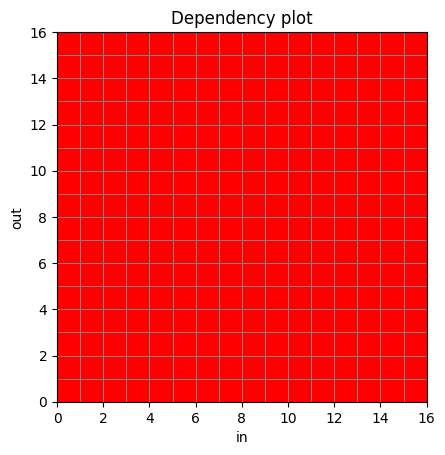

In [22]:
from speechbrain.lobes.models.transformer.TransformerASR import TransformerASR
from speechbrain.utils.streaming import infer_dependency_matrix, plot_dependency_matrix
from matplotlib import pyplot as plt

noncausal_model = TransformerASR(
    tgt_vocab=64, input_size=64, d_model=64, nhead=1, d_ffn=64, 
    encoder_module="conformer", normalize_before=True,
    num_encoder_layers=4, num_decoder_layers=0,
    causal=False
)
noncausal_model.eval()
noncausal_deps = infer_dependency_matrix(noncausal_model.encode, seq_shape=[1, 16, 64])
plot_dependency_matrix(noncausal_deps)
plt.show()

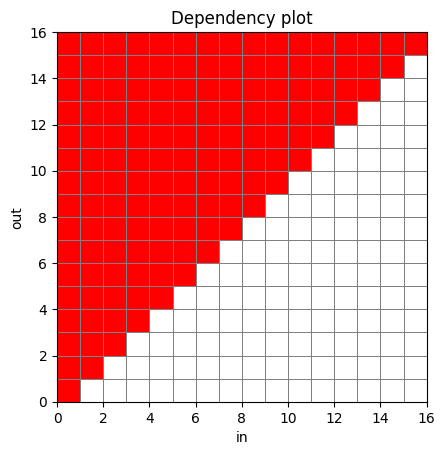

In [21]:
causal_model = TransformerASR(
    tgt_vocab=64, input_size=64, d_model=64, nhead=1, d_ffn=64, 
    encoder_module="conformer", normalize_before=True,
    num_encoder_layers=4, num_decoder_layers=0,
    causal=True
)
causal_model.eval()
causal_deps = infer_dependency_matrix(causal_model.encode, seq_shape=[1, 16, 64])
plot_dependency_matrix(causal_deps)
plt.show()

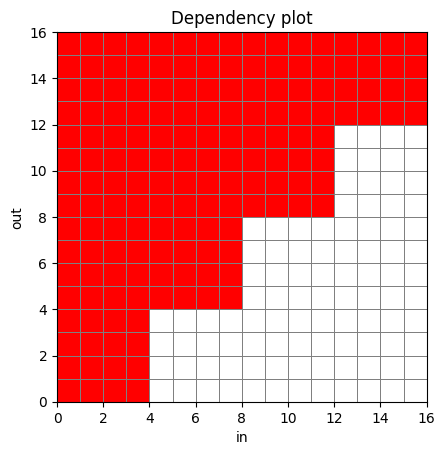

In [20]:
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfig

chunked_model = TransformerASR(
    tgt_vocab=64, input_size=64, d_model=64, nhead=1, d_ffn=64, 
    encoder_module="conformer", normalize_before=True,
    num_encoder_layers=4, num_decoder_layers=0,
    causal=False
)
chunked_model.eval()
chunked_conf = DynChunkTrainConfig(chunk_size=4, left_context_size=1)
chunked_deps = infer_dependency_matrix(lambda x: chunked_model.encode(x, dynchunktrain_config = chunked_conf), seq_shape=[1, 16, 64])
plot_dependency_matrix(chunked_deps)
plt.show()

As a reminder, it is normal for the _above_ to have e.g. the output at timestep $t=15$ depend on $t=0$.  
In none of the layers does $t=15$ _directly_ attend to $t=0$. Read the chunked attention section for more details.

If we want to see pure chunking without any left context, we can reduce the kernel size of the convolution module, disable left context entirely, and observe the following:

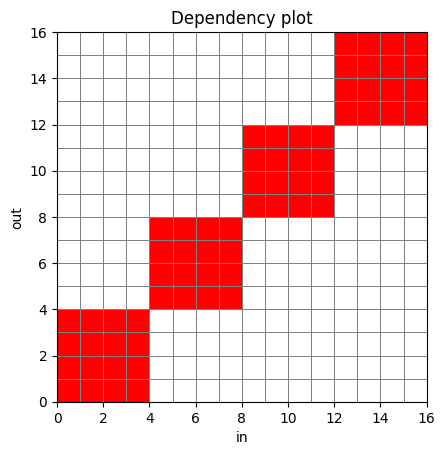

In [28]:
from speechbrain.utils.dynamic_chunk_training import DynChunkTrainConfig

chunked_model = TransformerASR(
    tgt_vocab=64, input_size=64, d_model=64, nhead=1, d_ffn=64, 
    encoder_module="conformer", normalize_before=True,
    num_encoder_layers=4, num_decoder_layers=0,
    kernel_size=1,
    causal=False
)
chunked_model.eval()
chunked_conf = DynChunkTrainConfig(chunk_size=4, left_context_size=0)
chunked_deps = infer_dependency_matrix(lambda x: chunked_model.encode(x, dynchunktrain_config = chunked_conf), seq_shape=[1, 16, 64])
plot_dependency_matrix(chunked_deps)
plt.show()

## Alternatives and Further Reading

This tutorial covered the modification of a mostly-vanilla Conformer model for chunkwise streaming support.  
Over the years, alternatives and improvements to the Conformer model have been developed, in order to improve accuracy, improve runtime performance, lower memory usage, lower real-world latency, or add miscellaneous features.  
The following is far from being a complete list, and it doesn't only include architectures that have been successfully adapted to a streaming context.

<!-- TODO: proper citations -->

- [Branchformer](https://arxiv.org/abs/2207.02971) (and [E-Branchformer](https://arxiv.org/abs/2210.00077))
- [Zipformer](https://arxiv.org/abs/2310.11230) (implemented by k2/[icefall](https://github.com/k2-fsa/icefall), among other Conformer variants, with streaming support implemented)
- [FastConformer](https://arxiv.org/abs/2305.05084) (still heavily used by NVIDIA as of 2024, despite its simplicity, and easy to migrate to from a vanilla Conformer)

There is also a lot of research around other parts of the training or inference pipeline:

- [Pruned RNN-T](https://arxiv.org/abs/2206.13236)

## Citing SpeechBrain

If you use SpeechBrain in your research or business, please cite it using the following BibTeX entry:

```bibtex
@misc{speechbrainV1,
  title={Open-Source Conversational AI with {SpeechBrain} 1.0},
  author={Mirco Ravanelli and Titouan Parcollet and Adel Moumen and Sylvain de Langen and Cem Subakan and Peter Plantinga and Yingzhi Wang and Pooneh Mousavi and Luca Della Libera and Artem Ploujnikov and Francesco Paissan and Davide Borra and Salah Zaiem and Zeyu Zhao and Shucong Zhang and Georgios Karakasidis and Sung-Lin Yeh and Pierre Champion and Aku Rouhe and Rudolf Braun and Florian Mai and Juan Zuluaga-Gomez and Seyed Mahed Mousavi and Andreas Nautsch and Xuechen Liu and Sangeet Sagar and Jarod Duret and Salima Mdhaffar and Gaelle Laperriere and Mickael Rouvier and Renato De Mori and Yannick Esteve},
  year={2024},
  eprint={2407.00463},
  archivePrefix={arXiv},
  primaryClass={cs.LG},
  url={https://arxiv.org/abs/2407.00463},
}
@misc{speechbrain,
  title={{SpeechBrain}: A General-Purpose Speech Toolkit},
  author={Mirco Ravanelli and Titouan Parcollet and Peter Plantinga and Aku Rouhe and Samuele Cornell and Loren Lugosch and Cem Subakan and Nauman Dawalatabad and Abdelwahab Heba and Jianyuan Zhong and Ju-Chieh Chou and Sung-Lin Yeh and Szu-Wei Fu and Chien-Feng Liao and Elena Rastorgueva and François Grondin and William Aris and Hwidong Na and Yan Gao and Renato De Mori and Yoshua Bengio},
  year={2021},
  eprint={2106.04624},
  archivePrefix={arXiv},
  primaryClass={eess.AS},
  note={arXiv:2106.04624}
}
```